In [2]:
### Setup
%matplotlib inline
# %load_ext pretty_jupyter

# should enable plotting without explicit call .show()

# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from matplotlib.colors import LogNorm

# classes for special types
from pandas.api.types import CategoricalDtype

# Apply the default theme
sns.set_theme()

## Introduction

In this report, we're going to predict how many goals will NHL players score next season. The prediction will be based on various player's data, such as average ice-time, age, shooting percentage, etc.

## Dataset overview

The provided dataset consists of 2 csv files:

### `nhl-teams.csv`:

This file contains names of NHL teams together with their short name.
There are 35 rows (1 row = 1 team) and only 2 columns. The structure is as follows:


In [3]:
# Reading and inspecting data
df = pd.read_csv("data/nhl-teams.csv")
df.head(5)

,team,team_full
0,ANA,Anaheim Ducks
1,ARI,Arizona Coyottes
2,ATL,Atlanta Thrashers
3,BOS,Boston Bruins
4,BUF,Buffalo Sabres


### `nhl-player-data.csv`

This file contains various data about NHL players (goals, points per season, average time on ice, age, etc.) for seasons 2004-2018.
Each row contains data for the given player per season, i.e. if the player has played multiple seasons in NHL, there will be multiple rows containing his data (1 row per each season).

Size of the dataset is about 1.34 MB  
There are 12328 rows and 32 columns

Structure is as follows:


In [4]:
df = pd.read_csv("data/nhl-player-data.csv")
df.head(5)

,Rk,Player,Nick,Age,Pos,Tm,GP,G,A,PTS,...,TOI,ATOI,BLK,HIT,FOW,FOL,FO_percent,HART,Votes,Season
0,1,Connor McDavid,mcdavco01,20,C,EDM,82,30,70,100,...,1733,21.133333,29.0,34,348.0,458.0,43.2,1,1604,2017
1,2,Sidney Crosby,crosbsi01,29,C,PIT,75,44,45,89,...,1491,19.883333,27.0,80,842.0,906.0,48.2,0,1104,2017
2,3,Patrick Kane,kanepa01,28,RW,CHI,82,34,55,89,...,1754,21.400000,15.0,28,7.0,44.0,13.7,0,206,2017
3,4,Nicklas Backstrom,backsni02,29,C,WSH,82,23,63,86,...,1497,18.266667,33.0,45,685.0,648.0,51.4,0,60,2017
4,5,Nikita Kucherov,kucheni01,23,RW,TBL,74,40,45,85,...,1438,19.433333,20.0,30,0.0,0.0,0.0,0,119,2017


Types of the columns are displayed below:


In [5]:
df.dtypes

Rk              int64
Player         object
Nick           object
Age             int64
Pos            object
Tm             object
GP              int64
G               int64
A               int64
PTS             int64
plusminus       int64
PIM             int64
PS            float64
EV              int64
PP              int64
SH              int64
GW              int64
EV.1            int64
PP.1            int64
SH.1            int64
S               int64
S_percent     float64
TOI             int64
ATOI          float64
BLK           float64
HIT             int64
FOW           float64
FOL           float64
FO_percent    float64
HART            int64
Votes           int64
Season          int64
dtype: object

As we mentioned before, we're mostly interested in predicting goals per season.
The distribution of goals per season in our dataset looks like this:


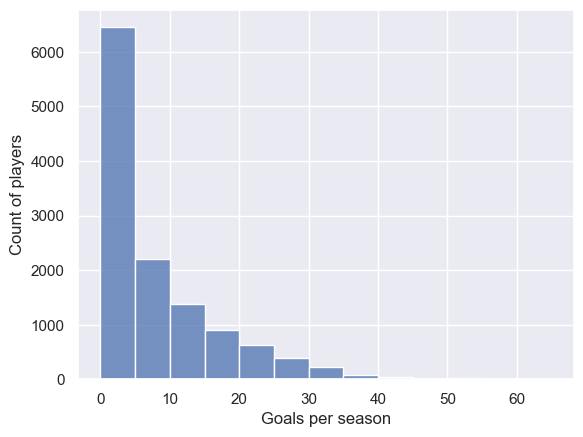

In [6]:
g = sns.histplot(data=df, x="G", binwidth=5)
plt.xlabel("Goals per season")
plt.ylabel("Count of players")

plt.show()

Here are the descriptive statistics:


In [7]:
df["G"].describe()

count    12328.000000
mean         7.484263
std          8.846936
min          0.000000
25%          1.000000
50%          4.000000
75%         11.000000
max         65.000000
Name: G, dtype: float64

We can see, that the average player scores about 7.5 goals per season, the maximum is 65 goals per season, and over 20% of players didn't score any goal in a season.


The graph below shows distribution of players by season.


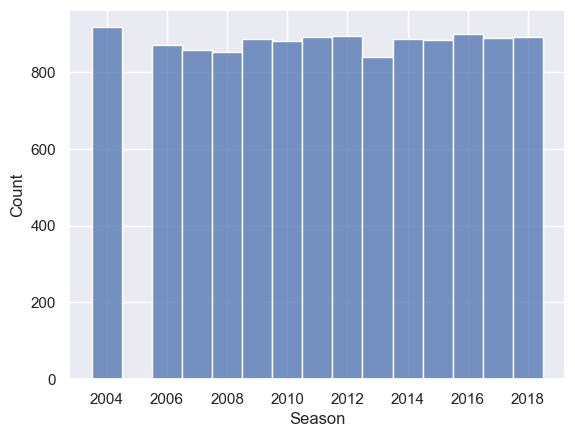

In [8]:
g = sns.histplot(data=df, x="Season", discrete=True)

We can see that the data are evenly distributed between seasons, however data for 2005 are missing because the season was cancelled.


#### Missing values

In total there are 438 missing cells in the dataset, which is about 0.1% of all cells.
These are mostly concentrated in two columns:

- FO_percent (faceoff win percentage)
- S_percent (shooting percentage)

In my opinion, this is most likely caused by the fact that the given players didn't take any faceoffs during the season (e.g. defensemen typically don't take faceoffs), or respectively didn't shoot at the goal (maybe the given player played just 1 game in whole season). Both cases will result in division by zero.

There is also 1 missing value in each of the following columns: BLK, FOW and FOL.

Missing values aren't denoted by any special strings (such as "None" or "Null"), there are just 2 consecutive commas in the given row.

There is one row with player whose age is 0, which is definitely an error in the dataset.


## Exploratory analysis

We're going to explore relations in the dataset.

Note: Players who scored 0 goals in a given season are excluded from all graphs.

### Goals & player's age

Firstly, we're going to explore whether the player's age correlates with the goals scored in any way.


In [9]:
df = df.loc[df["G"] > 0]

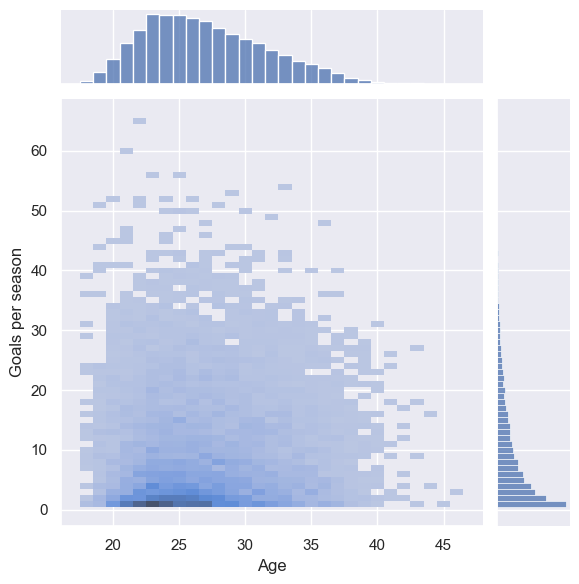

In [10]:
g = sns.JointGrid(data=df, x="Age",y="G")
g1 = g.plot(sns.histplot, sns.histplot, discrete=True)
g2 = g1.set_axis_labels("Age", "Goals per season")

From the graph above, we see that suprisingly, there is no visible correlation between these 2 variables. The best results belong to players aged 20-25 results, however these players are also the most represented group in the dataset.


### Goals & shooting percentage

In this part, we'll explore whether the goals scored depend on player's shooting percentage.  
Here is a graph showing relation of these 2 variables.


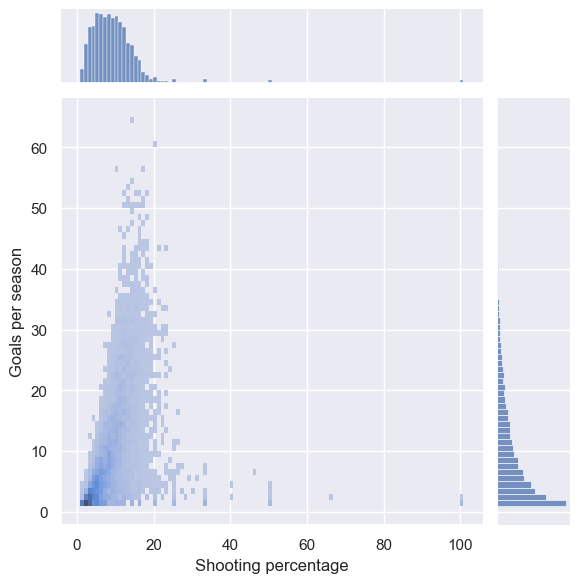

In [11]:
df_scored = df.loc[df["S_percent"] > 0]
g = sns.JointGrid(data=df_scored, x="S_percent",y="G")
g1 = g.plot(sns.histplot, sns.histplot, binwidth=1)
g2 = g1.set_axis_labels("Shooting percentage", "Goals per season")

From the graph, it seems that the number of goals directly depends on shooting percentage.
So, we can formulate the following hypothesis: The better shoting percentage, the more goals scored.

Of course, this doesn't apply to all data (e.g. there are several players with shooting percentage >= 50% and none of them scored more than 5 goals), however on average it seems to be true.


### Goals & average time on ice

In this section, we're going to explore relation between goals scored and average time on ice.  
Here is the graph showing relation between these 2 variables:


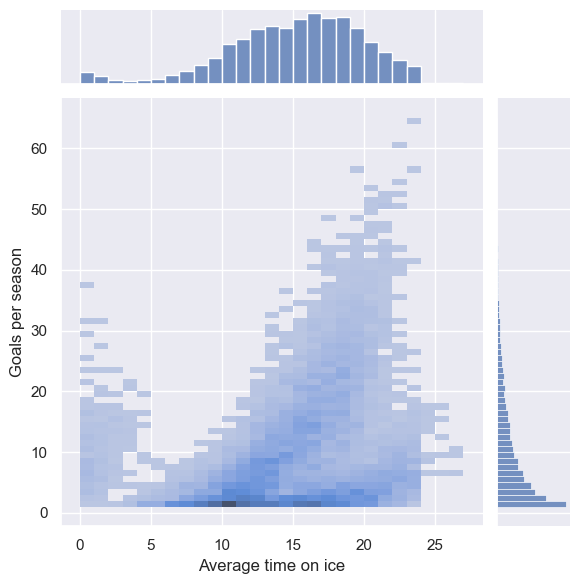

In [12]:
g = sns.JointGrid(data=df, x="ATOI",y="G")
g1 = g.plot(sns.histplot, sns.histplot, binwidth=1)
g2 = g1.set_axis_labels("Average time on ice", "Goals per season")

We can observe that the graph contains 2 clusters (one goes from `average time on ice = 10` up right and second one goes from the same position to the right).

In my opinion, the first cluster contains forwards and the second one contains defencemen, who often spend a lot of time on ice, however don't score as much as forwards.
There is also some strange data at the left showing players who spend on average < 5 minutes on ice, but score many goals (over 10 or even 20 goals per season).

The following graph shows the same relation but this time only for forwards:


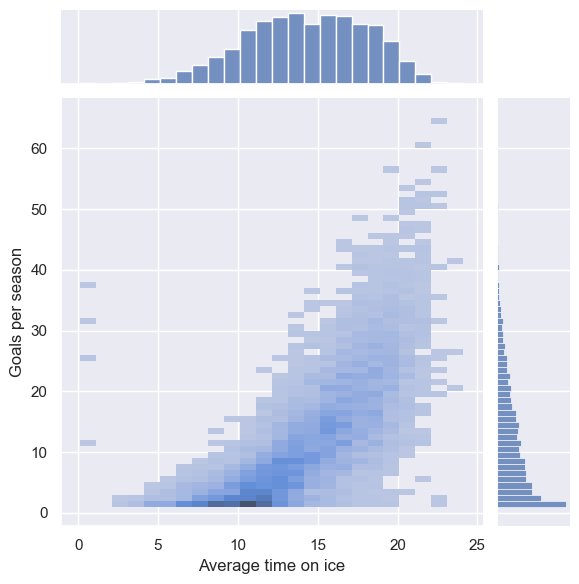

In [13]:
df_forwards = df.loc[df["Pos"].isin(["C","LW","RW"])]

g = sns.JointGrid(data=df_forwards, x="ATOI",y="G")
g1 = g.plot(sns.histplot, sns.histplot, binwidth=1)
g2 = g1.set_axis_labels("Average time on ice", "Goals per season")

We can see that the first cluster indeed mostly consists of forwards.  
The graph also suggests that for **forwards**, we can formulate the following hypothesis: Number of scored goals directly depends on average time on ice (the higher ice time, the more goals).

The same graph but for defencemen, looks like this:


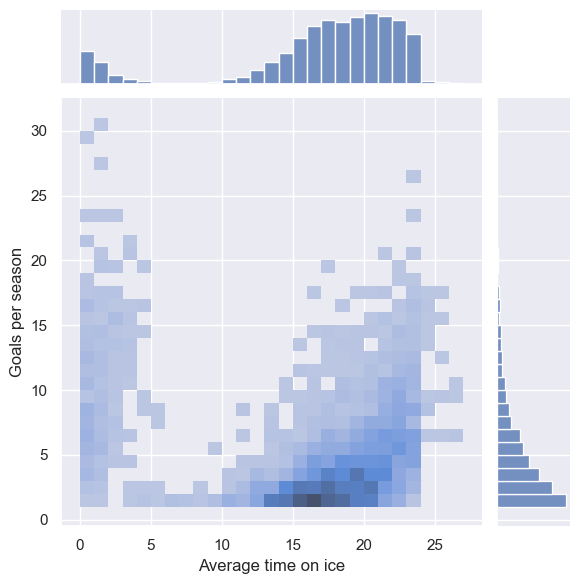

In [14]:
df_forwards = df.loc[df["Pos"] == "D"]

g = sns.JointGrid(data=df_forwards, x="ATOI",y="G")
g1 = g.plot(sns.histplot, sns.histplot, binwidth=1)
g2 = g1.set_axis_labels("Average time on ice", "Goals per season")

We can observe that most of the strange data (players who spend on average < 5 minutes on ice, but score many goals) from the graph above belong to defencemen.

After looking at these suspicious data, we see that the average time on ice is miscalculated.
If we divide total time on ice (TOI) by games played (GP), we should get average time on ice (ATOI). However, for these data ATOI is way smaller (mostly in the range 0-5) than the real value (see `ATOI_real` column in the table below). Therefore, it's an error in the data (for further data processing, we may recalculate ATOI values).


In [15]:
df_sus = df.loc[(df["G"] > 10) & (df["ATOI"] <= 2) & (df["Pos"] == "D"),["Player","Season","Pos","GP","G","TOI","ATOI"]]
df_sus["ATOI_real"] = df_sus["TOI"] / df_sus["GP"]
df_sus.head(5)

,Player,Season,Pos,GP,G,TOI,ATOI,ATOI_real
8,Brent Burns,2017,D,82,29,2039,0.866667,24.865854
15,Victor Hedman,2017,D,79,16,1936,0.500000,24.506329
107,Roman Josi,2017,D,72,12,1805,1.066667,25.069444
110,Alex Pietrangelo,2017,D,80,14,2023,1.283333,25.287500
148,Shea Weber,2017,D,78,17,1955,1.066667,25.064103


After exluding these error data, we see that for defencemen, there is a similar hypothesis: Higher average time on ice typically means more scored goals.


## Data cleaning

As mentioned before, there are some wrong data in the dataset.
I executed the following steps in order to clean it:

- removed the player, whose age is 0
- removed the players that had missing values in columns BLK, FOW and FOL (3 rows in total)
- replaced missing values in `S_percent` column by zeros. I checked that all of the players, whose `S_percent` value is missing, scored zero goals, therefore setting it to zero is correct.
- similarly, I replaced missing `FO_percent` values by zeros (again, I checked that these players didn't win any faceoff).
- recalculated all `ATOI` values (as mentioned in the previous section, some of the values are wrong).


In [16]:
df = pd.read_csv("data/nhl-player-data.csv")
df = df.loc[df["BLK"].notna() & (df["FOW"].notna()) & (df["FOL"].notna()) & (df["Age"] > 0)]
df["ATOI"] = df["TOI"] / df["GP"]

df["S_percent"] = df["S_percent"].fillna(0)
df["FO_percent"] = df["FO_percent"].fillna(0)

## Modeling

TODO: model pro goly, poslednich X sezon

mozna rozdelit na utocniky a obrance?


In [79]:
def get_three_consecutives(numbers):
    numbers.sort()
    if len(numbers) < 4:
        return None
        
    consecutives, has_results = [], False
    
    for i in range(len(numbers) - 3):
        y1, y2, y3, y4 = numbers[i:i+4]
        if y1 + 1 == y2 and y1 + 2 == y3 and y1 + 3 == y4:
            consecutives += [(y1, y2, y3, y4)]
            has_results = True

    return consecutives if has_results else None


def normalize(row):
    seasons, last_season = row["Con_seasons"][:-1], row["Con_seasons"][-1]
    indexes = [row["Season"].index(s) for s in seasons]
    target_index = row["Season"].index(last_season)

    row["target"] = row["G"][target_index]
    row["G"] = [row["G"][i] for i in indexes]
    row["GP"] = [row["GP"][i] for i in indexes]
    row["plusminus"] = [row["plusminus"][i] for i in indexes]
    row["S_percent"] = [row["S_percent"][i] for i in indexes]
    row["ATOI"] = [row["ATOI"][i] for i in indexes]
    row["Pos"] = row["Pos"][0]

    return row


players_agg = df.groupby(["Player"]).aggregate(lambda x: list(x))
players_agg["Con_seasons"] = players_agg["Season"].apply(get_three_consecutives)
players_agg = players_agg.loc[players_agg["Con_seasons"].notna()] # about half of records
players_agg = players_agg.explode("Con_seasons")
players_agg = players_agg.apply(normalize, axis=1)

players_agg = players_agg[["Pos", "GP", "G", "plusminus", "S_percent", "ATOI", "target"]]
players_agg


,Pos,GP,G,plusminus,S_percent,ATOI,target
Player,,,,,,,
Aaron Downey,RW,"[56, 21, 42]","[0, 1, 3]","[0, -6, 2]","[0.0, 10.0, 14.3]","[4.589285714285714, 5.0, 5.595238095238095]",1
Aaron Ekblad,D,"[68, 78, 81]","[10, 15, 12]","[-23, 18, 12]","[4.4, 8.2, 7.1]","[21.455882352941178, 21.67948717948718, 21.814...",16
Aaron Gagnon,C,"[10, 7, 19]","[3, 0, 0]","[2, -1, -3]","[27.3, 0.0, 0.0]","[8.2, 9.428571428571429, 8.052631578947368]",0
Aaron Johnson,D,"[56, 41, 38]","[3, 4, 3]","[-12, -6, 19]","[4.8, 11.1, 11.1]","[16.5, 15.658536585365853, 14.131578947368421]",0
Aaron Johnson,D,"[41, 38, 30]","[4, 3, 0]","[-6, 19, 2]","[11.1, 11.1, 0.0]","[15.658536585365853, 14.131578947368421, 13.86...",3
...,...,...,...,...,...,...,...
Zenon Konopka,C,"[37, 55, 82]","[0, 3, 2]","[-4, -4, -14]","[0.0, 8.8, 3.6]","[8.432432432432432, 7.836363636363636, 10.1951...",2
Zenon Konopka,C,"[55, 82, 74]","[3, 2, 2]","[-4, -14, -11]","[8.8, 3.6, 4.9]","[7.836363636363636, 10.195121951219512, 8.1351...",0
Zenon Konopka,C,"[82, 74, 7]","[2, 2, 0]","[-14, -11, -1]","[3.6, 4.9, 0.0]","[10.195121951219512, 8.135135135135135, 7.0]",0
